In [1]:
import numpy as np
import scipy.io 
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Load the data

In [5]:
# TODO Tobias: do this for all other data as well
mat = scipy.io.loadmat('sample_1.mat')
real_st = mat['spike_times'][0,0][0]  # actual spike times
data = mat['data'].T

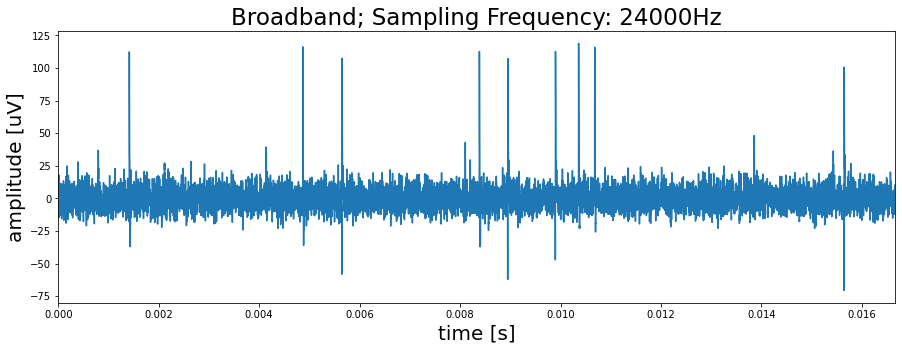

In [6]:
time=np.linspace(0,2,2880000)
sf=24000
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time[0:sf], data[0:sf])
ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(sf), fontsize=23)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()

# 1. Spike extraction

In [7]:
sigma_n = np.median((np.abs(data)/0.675))  # assuming data is band filtered
threshold = 3.384*sigma_n  # arbitrary value to fit to real data
estim_st_unaligned = np.argwhere(data > np.median(data)+threshold).T.flatten()

# remove duplicates
ind = np.where(np.diff( # 70 cuz of minimal refractory period
    estim_st_unaligned) > 70)[0] +1  # +1 to get start instead of end of spikes
estim_st_unaligned = estim_st_unaligned[ind]

In [8]:
# align spikes such that maximum is at the middle
def align_spikes(data, spike_times):
    spike_form = []
    for st in np.int_(spike_times):
        max_point = np.argmax(data[st-100 : st+100]) + (st-100) # find maxima in the vicinity
        spike_slice = data[max_point-24:max_point+24]  # need 48 points for 2ms
        spike_form.append(spike_slice)
    return np.array(spike_form)[:,:,0]

estim_sf = align_spikes(data, estim_st_unaligned)
real_sf = align_spikes(data, real_st)  # based on real st, get spike forms around real st

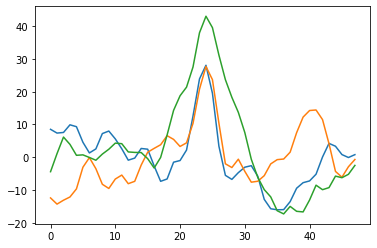

In [9]:
# visualization of few aligned spikes
plt.plot(estim_sf[0])
plt.plot(estim_sf[200])
plt.plot(estim_sf[10])

# 2. PCA

In [10]:
np.mean(estim_sf, axis=0).shape

(48,)

In [11]:
np.argmax(estim_sf[0])

24

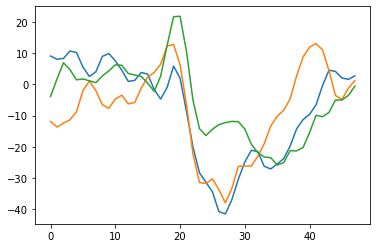

In [12]:
# centering
centered_spikes = estim_sf - np.mean(estim_sf, axis=0)
plt.plot(centered_spikes[0])
plt.plot(centered_spikes[200])
plt.plot(centered_spikes[10])

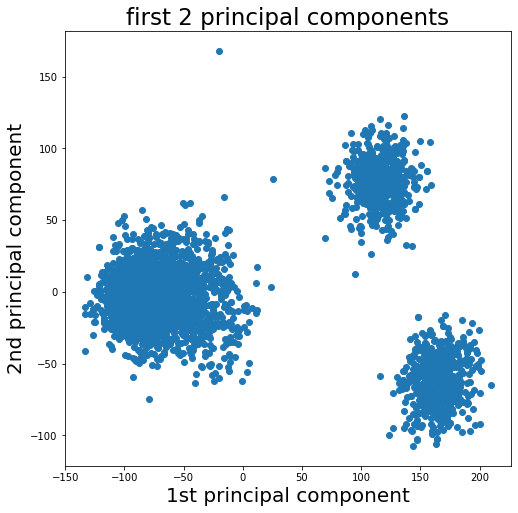

In [13]:
# Do PCA
pca = PCA(n_components=2)
estim_projected = pca.fit_transform(centered_spikes)
real_projected = pca.fit_transform(real_sf - np.mean(real_sf, axis=0))  # project spike forms for cluster viz

# Plot the 1st principal component aginst the 2nd
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(estim_projected[:, 0], estim_projected[:, 1])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 2 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Clustering

In [14]:
# k mean clustering using pre-built lib
num_clus = 3
centers = KMeans(n_clusters=num_clus).fit(estim_projected).cluster_centers_
cluster = KMeans(n_clusters=num_clus).fit_predict(estim_projected)

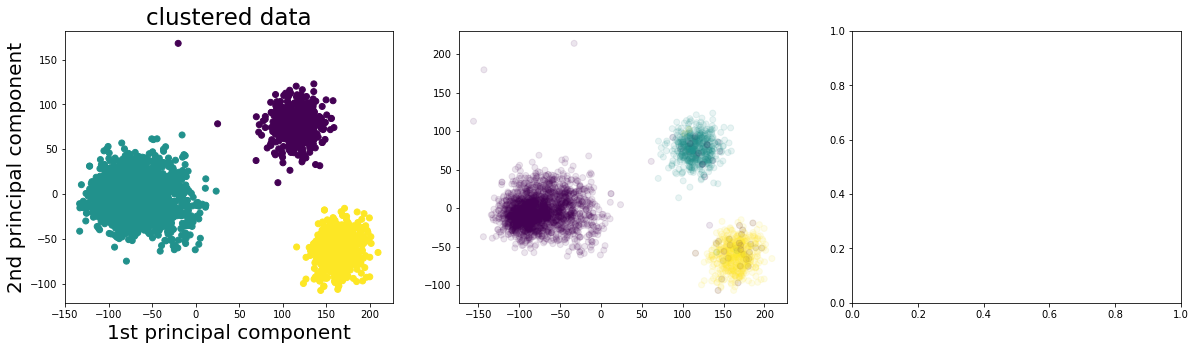

In [15]:
sf=24000

# Plot the clusters of estimation
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(estim_projected[:, 0], estim_projected[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

# plot actual clusters
ax[1].scatter(real_projected[:, 0], real_projected[:, 1], c=mat['spike_class'][0,0], alpha=0.1)


# # TODO Akhil: project back to original space 
# time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
# for i in range(num_clus):
#     cluster_mean = wave_form[cluster==i, :].mean(axis=0)
#     cluster_std = wave_form[cluster==i, :].std(axis=0)
    
#     ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
#     ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

# ax[1].set_title('average waveforms', fontsize=23)
# ax[1].set_xlim([0, time[-1]])
# ax[1].set_xlabel('time [ms]', fontsize=20)
# ax[1].set_ylabel('amplitude [uV]', fontsize=20)

# plt.legend()
# plt.show()